### Modeling Inflation Using VAR: A Survey Between Conventional and ML-based Approaches

The goal of this project is to understand how feature selection from Lasso and XGBoost can improve the forecasting accuracy of vector autoregressive models (VAR). I use a large dataset of US economic indicators constructed by economists, Michael McCracken and Serena Ng: https://research.stlouisfed.org/econ/mccracken/fred-databases. In this project, I will compare the in-sample forecasts of Consumer Price Index (CPI) using three separate VARs:
* VAR with variables selected using standard economic literature.
* VAR with features selected by Lasso
* VAR with features selected by XGBoost 

In [119]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd 
import seaborn as sns
sns.set()
import datetime as dt
import warnings
warnings.simplefilter('ignore')

from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)
import statsmodels.formula.api as sm

!pip install xgboost
from xgboost import XGBRegressor, plot_importance


#### Data visualization and exploration

First, I visualize and explore some macroeconomic indicators to assist the variable selection for my VAR.

In [120]:
# Some cleaning
fred = pd.read_csv("fredmd.csv")

fred = fred.drop(0)
fred["sasdate"] = pd.to_datetime(fred["sasdate"])
fred = fred.rename(columns={"sasdate": "date"})
fred = fred.set_index("date")

# Stationarity in yearly percentage change
for c in list(fred.columns.values):
    fred[c + "_diff"] = (fred[c] - fred[c].shift(12))/fred[c].shift(12) * 100

fred.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA_diff,CES0600000008_diff,CES2000000008_diff,CES3000000008_diff,UMCSENTx_diff,MZMSL_diff,DTCOLNVHFNM_diff,DTCTHFNM_diff,INVEST_diff,VXOCLSx_diff
date,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6250,23.4581,22.1904,32.4078,21.9882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0681,23.7747,22.3827,32.6455,22.1036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4004,23.9186,22.4925,32.6455,22.5365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-04-01,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8989,24.2641,22.8221,33.1606,22.6807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-05-01,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2589,24.4655,23.0418,33.3190,23.1424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Out of curiosity, I want to see whether the **unemployment rate**, **Fed Funds rate** and **stock market indicators** have any historical relationship with inflation. 

In [121]:
def scatter_plot(data, col_1, col_2, color):
    
    """
    Creates scatter plots for inflation, unemployment rate, Fed Funds rate, the S&P500 Composite Index
    """
    
    fig, ax = plt.subplots(figsize=(10,4))
    
    ax.scatter(x=data[col_1], y=data[col_2], alpha=0.4, color=color)
    ax.set_xlabel("Inflation", fontname="Verdana")
    
    if col_2 == "UNRATE":
        ax.set_title("Inflation and unemployment rate", fontsize=16, fontname="Verdana", loc="left")
        ax.set_ylabel("Unemployment rate", fontname="Verdana")
    elif col_2 == "S&P 500":
        ax.set_title("Inflation and S&P500", fontsize=16, fontname="Verdana", loc="left")
        ax.set_ylabel("S&P500", fontname="Verdana")
    else:
        ax.set_title("Inflation and Fed Funds rate", fontsize=16, fontname="Verdana", loc="left")
        ax.set_ylabel("Fed Funds rate", fontname="Verdana")


Economists often refer to the Phillips Curve, showing a trade-off between inflation and **unemployment**. Looking at the data, is this trade-off true? 

Do stock markets have any predictive power for inflation? I seek to explore the relationship between the inflation rate and **S&P500** Composite index.

The Fed Reserve lowers inflation by raising interest rates. Is the **Fed Funds rate** useful for prediction?

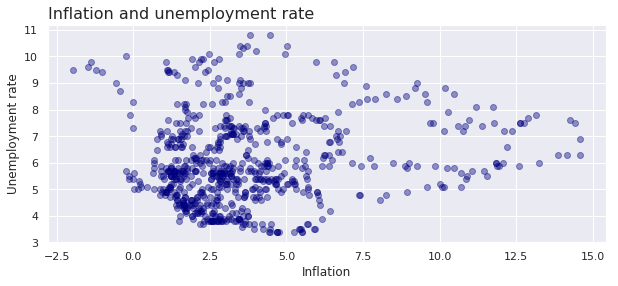

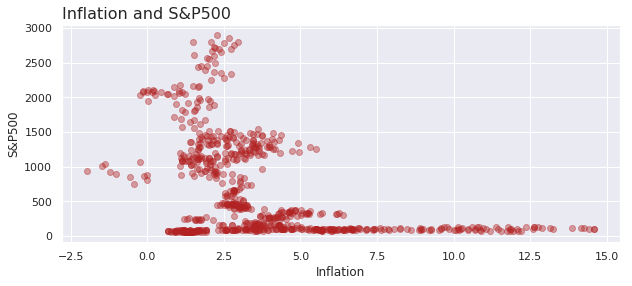

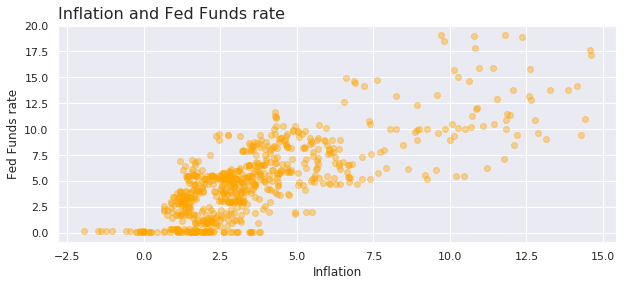

In [122]:
for f,c in dict(zip(["UNRATE", "S&P 500", "FEDFUNDS"], ["navy", "firebrick", "orange"])).items():
    scatter_plot(data=fred, col_1="CPIAUCSL_diff", col_2=f, color=c)

Despite some outliers, there appears a curved negative relation between the unemployment rate and inflation, providing some visual evidence for the Phillips Curve. This relation is broken down into various subsamples below. 

There's no clear relationship between stock markets and inflation, contrary to popular beliefs. This will not be too useful a variable for my VAR.

There appears to be a positive upward-sloping relationship between the Fed Funds rate and inflation. This is not surprising, given that monetary policy responds to inflation (and vice versa).

In [123]:
def scatter_subs(data, col_1, col_2, color):
    
    """
    Break down scatterplots into different years
    """
    
    data1 = data.loc["1960-01-01":"1979-12-01", :]
    data2 = data.loc["1980-01-01":"1999-12-01", :]
    data3 = data.loc["2000-01-01":"2019-01-01", :]

    fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)
    
    ax[0].scatter(x=data1[col_1], y=data1[col_2], alpha=0.4, color=color)
    ax[1].scatter(x=data2[col_1], y=data2[col_2], alpha=0.4, color=color)
    ax[2].scatter(x=data3[col_1], y=data3[col_2], alpha=0.4, color=color)

    ax[0].set_title("1960-1979", fontsize=14, fontname="Verdana")
    ax[1].set_title("1980-1999", fontsize=14, fontname="Verdana")
    ax[2].set_title("2000-2019", fontsize=14, fontname="Verdana")

    for i in list(range(3)):
        ax[i].set_xlabel("Inflation")
        if col_2 == "UNRATE":
            ax[i].set_ylabel("Unemployment rate (%)")
        elif col_2 == "S&P 500":
            ax[i].set_ylabel("S&P500")
        else:
            ax[i].set_ylabel("Fed funds rate")
            

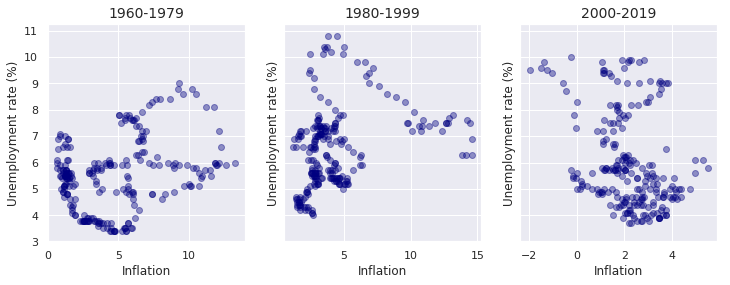

In [124]:
scatter_subs(data=fred, col_1="CPIAUCSL_diff", col_2="UNRATE", color="navy")

Outliers may be explained by trends in across 1970 and 1980. In the 70s, the US economy experienced high inflation. The clustering of low inflation values from 1980-1999 may correspond to the recession of the 1980s, following aggressive interest rate hikes by the Fed in response to the high inflation in the 70s.

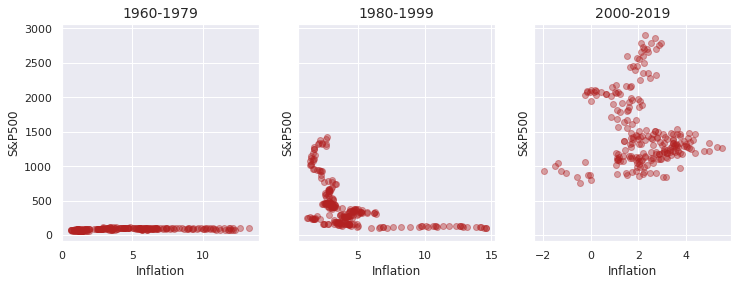

In [125]:
scatter_subs(data=fred, col_1="CPIAUCSL_diff", col_2="S&P 500", color="firebrick")

Across different subsamples of years, there does not appear to be any relationship between inflation and stock markets.

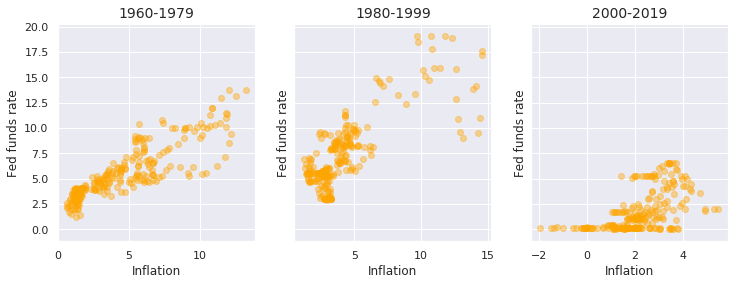

In [126]:
scatter_subs(data=fred, col_1="CPIAUCSL_diff", col_2="FEDFUNDS", color="orange")

In most intervals, the Fed funds rate has a positive, upward-sloping relationship with inflation. This makes sense as interest rates rise in response to inflation. Interest rates historically have been much higher than in recent times.

#### VAR: Traditional approach

In [127]:
from statsmodels.tsa.api import VAR

fred = pd.read_csv("fredmd.csv")

fred = fred.drop(0)
fred["sasdate"] = pd.to_datetime(fred["sasdate"])
fred = fred.rename(columns={"sasdate": "date"})
fred = fred.set_index("date")

# Stationarity
# First differences instead of percentage change
# It seems later on that Lasso had an issue fitting percentage change

for c in list(fred.columns.values):
    fred[c + "_diff"] = fred[c] - fred[c].shift(12)


My VAR model has 6 variables: Inflation, real personal income, unemployment rate, Fed Funds rate, a trade-weighted index of the US dollar with several major currencies and total housing starts, as well as 12 lags for each variable. $B$ represents a matrix of coefficients.

$$
\begin{bmatrix} \pi_{t} \\ rpi_{t} \\ unemp_{t} \\ fedrate_{t} \\ usd_{t} \\ houst_{t} \end{bmatrix} = \alpha_t + B_{t-1}\begin{bmatrix} \pi_{t-1} \\ rpi_{t-1} \\ unemp_{t-1} \\ fedrate_{t-1} \\ usd_{t-1} \\ houst_{t-1} \end{bmatrix} + \dots + B_{t-12}\begin{bmatrix} \pi_{t-12} \\ rpi_{t-12} \\ unemp_{t-12} \\ fedrate_{t-12} \\ usd_{t-12} \\ houst_{t-12} \end{bmatrix}+ \epsilon_t
$$


In [128]:
# Rename VAR variables

new_names = ["cpi", "rpi", "unemp", "fedrate", "usd", "houst"]
old_names = ["CPIAUCSL", "RPI", "UNRATE", "FEDFUNDS", "TWEXMMTH", "HOUST"]

for n,o in dict(zip(new_names, old_names)).items():
    fred = fred.rename(columns={o:n})
    
new_names_diff = ["cpi_diff", "rpi_diff", "unemp_diff", "fedrate_diff", "usd_diff", "houst_diff"]
old_names_diff = ["CPIAUCSL_diff", "RPI_diff", "UNRATE_diff", "FEDFUNDS_diff", "TWEXMMTH_diff", "HOUST_diff"]

for nd,od in dict(zip(new_names_diff, old_names_diff)).items():
    fred = fred.rename(columns={od:nd})
    
fred.head()

,rpi,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA_diff,CES0600000008_diff,CES2000000008_diff,CES3000000008_diff,UMCSENTx_diff,MZMSL_diff,DTCOLNVHFNM_diff,DTCTHFNM_diff,INVEST_diff,VXOCLSx_diff
date,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6250,23.4581,22.1904,32.4078,21.9882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0681,23.7747,22.3827,32.6455,22.1036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4004,23.9186,22.4925,32.6455,22.5365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-04-01,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8989,24.2641,22.8221,33.1606,22.6807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-05-01,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2589,24.4655,23.0418,33.3190,23.1424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
def plot_vars(data, levels, color, leveltype):
    
    """
    Displays historical trends of VAR variables
    And see if it's sensible to just select levels instead of differences
    """
    
    fig, ax = plt.subplots(1, 6, figsize=(16,2.5), sharex=True)
    
    palettes = ["blue", "green", "red", "orange", "purple", "black"]
    
    for col, i in dict(zip(levels, list(range(6)))).items():
        data[col].plot(ax=ax[i], legend=True, linewidth=1.0, color=color, sharex=True)     
    
    fig.set_facecolor("floralwhite")
    fig.suptitle(f"Historical trends of VAR {leveltype} variables", 
                 fontsize=14, fontweight="bold", fontname="Verdana")


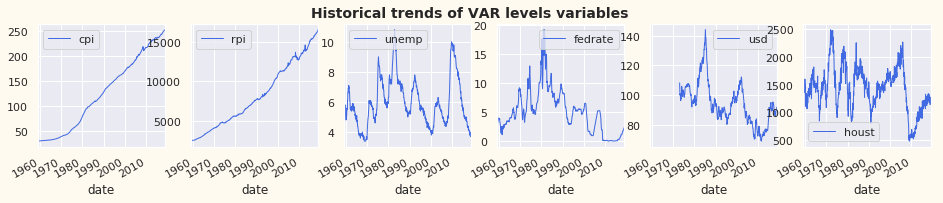

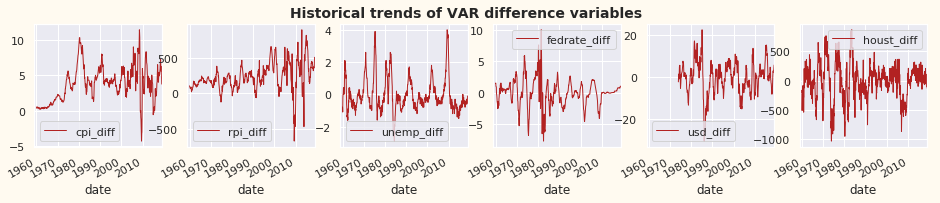

In [130]:
plot_vars(fred, levels=new_names, color="royalblue", leveltype="levels")
plot_vars(fred, levels=new_names_diff, color="firebrick", leveltype="difference")

Check for *stationarity*: Inflation and real personal income levels are clearly not stationary. I take the first differences in Fed Funds rate and trade-weighted USD index. Unemployment rate in levels looks stationary.

In [131]:

start_date = "2009-02-01"
end_date = "2019-01-01"

def var_create(columns, data):
    
    """
    Creates vector autoregressive model given data and list of selected variables
    Returns the MSE between forecasted and actual values
    Also returns the concatenated dataset for visualization purposes
    """
    
    data = data[columns]
    data = data.dropna(axis=0)
    data.index.to_period("M")
    
    # Split dataset and run VAR on the trained part
    data_train = data.loc["1973-01":"2009-01", :]
    var_train = VAR(data_train)
    results = var_train.fit(12)
    lag_order = results.k_ar
    forecasted = pd.DataFrame(results.forecast(data_train.values[-lag_order:], 120)) # Forecast 120 months
    
    # Rename forecasted columns
    forecasted_names = list(forecasted.columns.values)
    data_train_names = list(data_train.columns.values)
    
    var_dict = dict(zip(forecasted_names, data_train_names))
    
    for f,t in var_dict.items():
        forecasted = forecasted.rename(columns={f:t + "_fcast"})
        
    forecasted.index = pd.DatetimeIndex(start=start_date, periods=forecasted.shape[0], freq="MS")
    forecasted.index.names = ["date"]
    
    # Parse together forecasted data with original dataset
    final_data = pd.merge(forecasted, data, left_index=True, right_index=True)
    final_data = final_data.sort_index(axis=0, ascending=True)
    final_data = pd.concat([data_train, final_data], sort=True, axis=0)
    final_data = final_data.sort_index(axis=0, ascending=True)
    
    var_mse = metrics.mean_squared_error(final_data.loc[start_date:end_date,"cpi_diff_fcast"], 
                           final_data.loc[start_date:end_date,"cpi_diff"])
    
    return var_mse, final_data


In [132]:
mse1, df1 = var_create(columns=["unemp", "cpi_diff", "fedrate_diff", 
                    "usd_diff", "rpi_diff", "houst"], data=fred)

print(f"The mean squared error between the forecasted and actual values is {mse1}")

The mean squared error between the forecasted and actual values is 7.286750044362778


In [133]:
def plot_cpi(final_data, var_mse, approach):
    
    """
    Plots the actual values against forecast
    """
    
    fig, ax = plt.subplots(figsize=(14,6))
    colors = sns.color_palette("deep", 8)

    final_data["cpi_diff_fcast"].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed")
    final_data["cpi_diff"].plot(ax=ax, legend=True, alpha=0.6, linestyle="solid")
    
    if approach=="traditional":
        ax.set_title("VAR in-sample forecast, traditional approach", fontsize=16, 
                     fontweight="bold", fontname="Verdana", loc="left")
    elif approach=="lasso":
        ax.set_title("VAR in-sample forecast, Lasso approach", fontsize=16, 
                     fontweight="bold", fontname="Verdana", loc="left")
    elif approach=="XGBoost":
        ax.set_title("VAR in-sample forecast, XGBoost approach", fontsize=16, 
                     fontweight="bold", fontname="Verdana", loc="left")
    else:
        ax.set_title("VAR in-sample forecast", fontsize=16, 
                     fontweight="bold", fontname="Verdana", loc="left")
    
    ax.set_ylabel("First differences", fontname="Verdana")
    ax.legend([f"VAR Forecast, MSE={var_mse}", "CPI Real Values"])
    

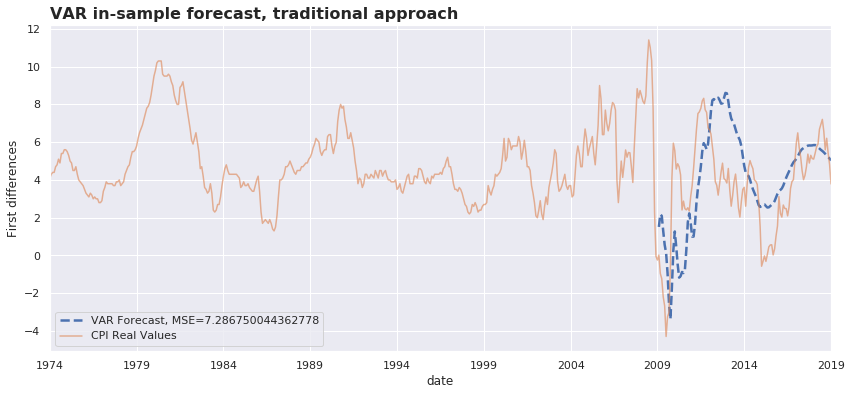

In [134]:
plot_cpi(final_data=df1, var_mse=mse1, approach="traditional")

The MSE is high, but the visualizations show that the VAR actually performs quite well over the forecast period.

#### VAR: Lasso approach

I now use Lasso to determine whether the features selected by VAR do a better job at predicting inflation. Does it select the same variables?

In [135]:
def timeseries_train_test_split(X, y, testsize):
    """
    This function splits the sample into a trained and test data
    """
    
    X_train = X.loc[:"2009-01-01"] # Until a particular date
    y_train = y.loc[:"2009-01-01"]
    X_test = X.loc["2009-01-01":]
    y_test = y.loc["2009-01-01":]
    
    return X_train, y_train, X_test, y_test

def train_test_plot(model, X_train, X_test):
    """
    This will plot the actual values of CPI against the one fitted by the model
    We train the model until 2009 and then use it from 2009 onwards on the test features dataset
    """
    fig, ax = plt.subplots(figsize=(12,4))
    colors = sns.color_palette("deep", 8)
    
    yvalues = pd.DataFrame(y_test)
    
    forecasted = list(model.predict(X_test)) # Use the model fit on features data from 2009 onwards
    df_fcast = pd.DataFrame({"date": list(yvalues.index), "cpi_fcast": forecasted})
    df_fcast = df_fcast.set_index("date")
    
    df = pd.merge(yvalues, df_fcast, left_index=True, right_index=True)

    df["cpi_fcast"].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed", color="forestgreen") # CPI fitted
    df["cpi_diff"].plot(ax=ax, legend=True, linewidth=1.5, linestyle="solid", color="salmon") # Actual CPI values
    
    ax.set_title("CPI vs. Model's CPI")
    ax.set_ylabel("First differences")
    ax.legend(["Fitted CPI","Actual CPI"])


In [136]:
# Split into X and y
cpi_target = fred.dropna().cpi_diff
fred_features = fred.dropna().drop(["cpi_diff"], axis=1)

One thing to realize is that in time series data, Lasso performs the k-folds on a rolling basis, as the data is folded across time observations.

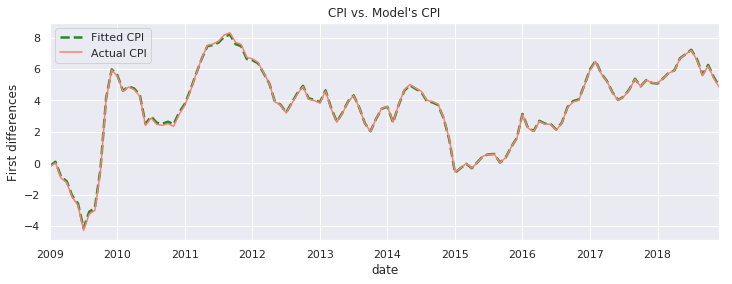

In [137]:
X_train, y_train, X_test, y_test = timeseries_train_test_split(X=fred_features, y=cpi_target, testsize=0.25)

lasso = linear_model.LassoCV(cv=model_selection.TimeSeriesSplit(n_splits=5), 
                             alphas=None, tol = 10000, normalize=True) 

fred_lasso = lasso.fit(X_train, y_train)
optimal_alpha = fred_lasso.alpha_

lasso2 = linear_model.Lasso(alpha=optimal_alpha, normalize=True)
lasso2.fit(X_train, y_train)

train_test_plot(lasso2, X_train, X_test) 

In [138]:
metrics.mean_squared_error(y_test, lasso2.predict(X_test))

0.0034125251955741003

The MSE is actually quite amazingly small, showing that the test data fitted into Lasso actually predicts CPI very well and closely fits with the actual values. Now for the feature selection:

In [139]:
lasso_coefs = pd.DataFrame({"features":list(X_train), "coef": lasso2.coef_})
lasso_coefs = lasso_coefs[lasso_coefs.coef != 0.0]
lasso_coefs.sort_values("coef", ascending=False)

,features,coef
241,CUSR0000SA0L5_diff,6.127093e-01
238,CUSR0000SAS_diff,1.211279e-01
236,CUSR0000SAC_diff,1.030416e-01
239,CPIULFSL_diff,7.999004e-02
240,CUSR0000SA0L2_diff,3.874445e-02
235,CPIMEDSL_diff,2.191615e-02
227,WPSFD49207_diff,5.983922e-04
104,PPICMM,2.228493e-04
231,OILPRICEx_diff,1.474625e-04
252,DTCTHFNM_diff,1.069641e-08


I got the definitions from McCracken's website: https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md/Appendix_Tables_Update.pdf, but I rename the features below. The five features that are selected by Lasso are **CPI - All items less medical**, **CPI - Services**, **CPI - Commodities**, **CPI - All items less food**, **CPI - All items less shelter** and **CPI - Medical care**. This is strange, considering concerns of multicollinearity. It's almost like a univariate regression breaking down CPI into different parts. Nonetheless, I use them in the VAR to see how they perform. 

In [140]:
old_names2 = ["CUSR0000SA0L5_diff", "CUSR0000SAS_diff", 
              "CUSR0000SAC_diff", "CPIULFSL_diff", "CUSR0000SA0L2_diff"]

new_names2 = ["cpi_lessmed", "cpi_serv", "cpi_comm", "cpi_lessfd", "cpi_lessshelt"]

for n,o in dict(zip(new_names2, old_names2)).items():
    fred = fred.rename(columns={o:n})

new_names2 = new_names2 + ["cpi_diff"]
mse2, df2 = var_create(columns=new_names2, data=fred)
print(f"The mean squared error between the forecasted and actual values is {mse2}")

The mean squared error between the forecasted and actual values is 9.667189233297316


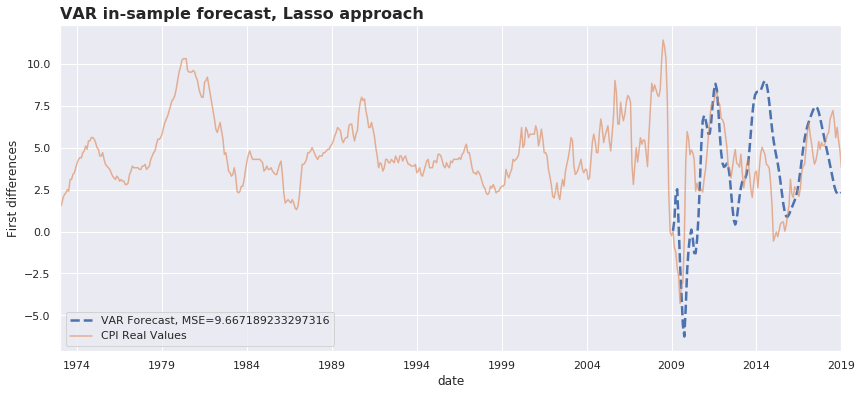

In [142]:
plot_cpi(final_data=df2, var_mse=mse2, approach="lasso")

The MSE is actually worse than that of the VAR using traditional approach. This shows that machine learning has its limits.

#### VAR: XGBoost approach

Next, I use XGBoost to select features for the VAR. It turns out that XGBoost and other tree-based models poorly handle trends in time series datasets. Ideally, I should restrict my dataset to stationary variables so that it doesn't 'read' variables that are trending upwards.

In [143]:
fred_features = fred_features[list(fred_features.filter(regex = "_diff"))] # Drop non-stationary variables 
X_train, y_train, X_test, y_test = timeseries_train_test_split(X=fred_features, y=cpi_target, testsize=0.25)


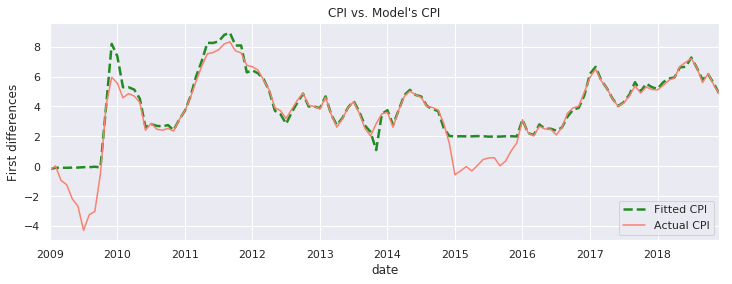

In [144]:
# Build XGBoost
# Normalize the features 
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

train_test_plot(model=xgb, X_train=X_train_scaled, X_test=X_test_scaled)


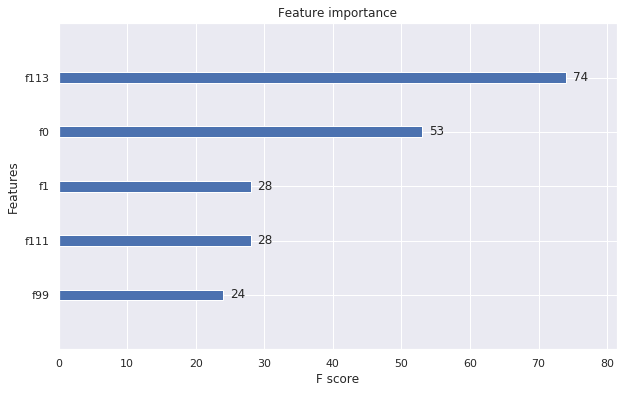

In [145]:
fig_xgb, ax_xgb = plt.subplots(figsize=(10,6))
plot_importance(xgb, max_num_features=5, ax=ax_xgb)

In [146]:
# Feature selection

for i, name in dict(zip(list(range(len(X_train.columns))), list(X_train.columns.values))).items():
    if i == 0:
        print(f"Feature {i} is {name}")
    elif i == 99:
        print(f"Feature {i} is {name}")
    elif i == 106:
        print(f"Feature {i} is {name}")
    elif i == 109:
        print(f"Feature {i} is {name}")
    elif i == 111:
        print(f"Feature {i} is {name}")


Feature 0 is rpi_diff
Feature 99 is WPSFD49207_diff
Feature 106 is CPITRNSL_diff
Feature 109 is CUSR0000SAD_diff
Feature 111 is CPIULFSL_diff


It turns out that **real personal income**, **PPI - Finished Goods**, **CPI - Transportation**, and **personal consumption expenditure (PCE)**, and **PCE - Non-durable goods** are the most important features for the XGBoost Regressor. I rename the variables for convenience below.

In [147]:
old_names3 = ["AMDMUOx", "cpi_lessmed", 
              "cpi_lessfd", "rpi", "PCEPI_diff"]

new_names3 = ["orders", "cpi_lessmed", "cpi_lessfd", "rpi", "pce_diff"]

for n,o in dict(zip(new_names3, old_names3)).items():
    fred = fred.rename(columns={o:n})

new_names3 = new_names3 + ["cpi_diff"]
mse3, df3 = var_create(columns=new_names3, data=fred)
print(f"The mean squared error between the forecasted and actual values is {mse3}")

The mean squared error between the forecasted and actual values is 60.42959678593003


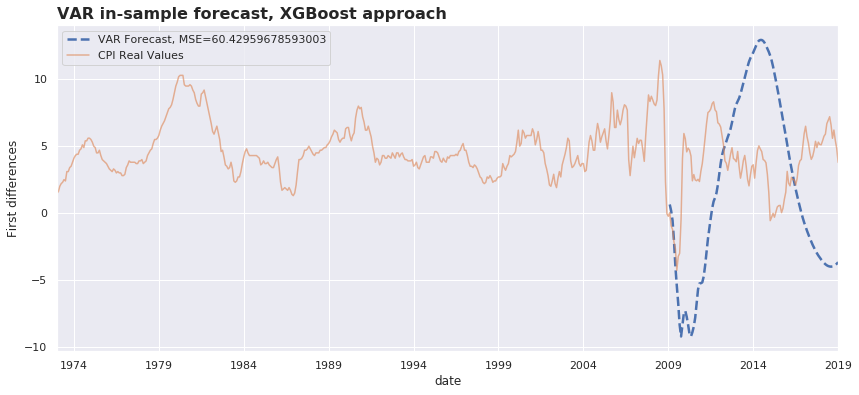

In [149]:
plot_cpi(final_data=df3, var_mse=mse3, approach="XGBoost")

The forecast is very poor. This highlights the challenges of using machine learning to select variables for forecasting.

#### Conclusions

From this exercise, it can be infereed that there's a fundamental difference between prediction/fit and forecasting. While the historical prediction of a model might be very good and training the model on a test dataset might yield low MSEs, forecasting with those same features is tricky. Because variables in VAR interact endogenously with each other, there's much uncertainty with how the selected features will trend over time. When it comes to forecasting, one needs to decide which variables are the most important and not just rely solely on fit. A summary of the MSEs between actual and forecasted values for each approach is provided below. 

Text(0, 0.5, 'MSE')

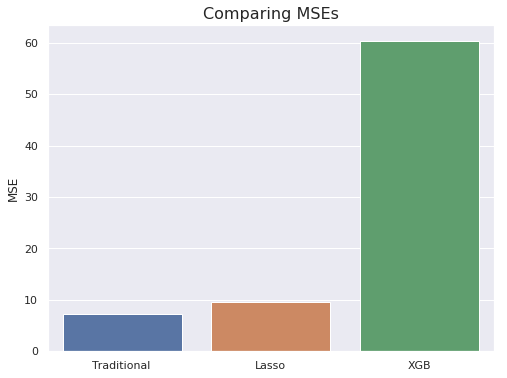

In [150]:
fig, ax = plt.subplots(figsize=(8,6))

ax = sns.barplot(x = ["Traditional", "Lasso", "XGB"], y = [mse1, mse2, mse3])
ax.set_title("Comparing MSEs", fontsize=16, fontname="Verdana")
ax.set_ylabel("MSE", fontname="Verdana")

After this exercise, I find that the traditional approach is much better than machine learning approaches. In terms of policy implications, there is still value in looking to economic theory (such as the Phillips Curve) to assist in forecasting.